#  The Battle of Neighborhoods

## Coursera IBM Data Science Capstone Project

*Mario Gasco Durán*

*May, 2020*

## Data Preparation

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup
import requests
import json # library to handle JSON files
import folium
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline

print('Libraries imported.')

Libraries imported.


### Madrid districts 

In [2]:
#Import data
List_url = "https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid"
source = requests.get(List_url).text
soup = BeautifulSoup(source, 'xml')

table=soup.find('table')

#Creating the dataframe
column_names = ['Number','District','Surface (ha.)','Population','Density (Hab./ha.)','Image','Neighborhoods']
df = pd.DataFrame(columns = column_names)

for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==7:
        df.loc[len(df)] = row_data


df.head()

,Number,District,Surface (ha.),Population,Density (Hab./ha.),Image,Neighborhoods
0,1,Centro,"&&&&&&&&&&&&0522.820000522,82",&&&&&&&&&0131928.&&&&&0131 928,"&&&&&&&&&&&&0252.340000252,34",,Palacio (11)Embajadores (12)Cortes (13)Justici...
1,2,Arganzuela,"&&&&&&&&&&&&0646.220000646,22",&&&&&&&&&0151965.&&&&&0151 965,"&&&&&&&&&&&&0235.160000235,16",,Imperial (21)Acacias (22)Chopera (23)Legazpi (...
2,3,Retiro,"&&&&&&&&&&&&0546.620000546,62",&&&&&&&&&0118516.&&&&&0118 516,"&&&&&&&&&&&&0216.820000216,82",,Pacífico (31)Adelfas (32)Estrella (33)Ibiza (3...
3,4,Salamanca,"&&&&&&&&&&&&0539.240000539,24",&&&&&&&&&0143800.&&&&&0143 800,"&&&&&&&&&&&&0266.670000266,67",,Recoletos (41)Goya (42)Fuente del Berro (43)Gu...
4,5,Chamartín,"&&&&&&&&&&&&0917.550000917,55",&&&&&&&&&0143424.&&&&&0143 424,"&&&&&&&&&&&&0156.310000156,31",,El Viso (51)Prosperidad (52)Ciudad Jardín (53)...


In [3]:
madrid_districts = df[['Number','District']]
madrid_districts.head()

,Number,District
0,1,Centro
1,2,Arganzuela
2,3,Retiro
3,4,Salamanca
4,5,Chamartín


In [4]:
#Import coordinates
coord= pd.read_excel('coord.xls')
coord.head()

,District,Latitude,Longitude
0,Centro,40.418308,-3.70275
1,Arganzuela,40.400021,-3.69618
2,Retiro,40.413170,-3.68307
3,Salamanca,40.429722,-3.67975
4,Chamartín,40.451000,-3.67500


In [5]:
madrid_districts=pd.merge(madrid_districts, coord, on='District')
madrid_districts.head()

,Number,District,Latitude,Longitude
0,1,Centro,40.418308,-3.70275
1,2,Arganzuela,40.400021,-3.69618
2,3,Retiro,40.413170,-3.68307
3,4,Salamanca,40.429722,-3.67975
4,5,Chamartín,40.451000,-3.67500


In [6]:
print('The number of districts in Madrid is: {}'.format(madrid_districts['District'].nunique()))

The number of districts in Madrid is: 21


### Madrid census population

In [7]:
#Import data
census= pd.read_excel('16_to_64_population.xls')
census.head()

,District,Population16 to 64 ages
0,Centro,102.065
1,Arganzuela,104.784
2,Retiro,73.652
3,Salamanca,94.649
4,Chamartín,91.757


In [8]:
madrid_districts=pd.merge(madrid_districts, census, on='District')
madrid_districts.head()

,Number,District,Latitude,Longitude,Population16 to 64 ages
0,1,Centro,40.418308,-3.70275,102.065
1,2,Arganzuela,40.400021,-3.69618,104.784
2,3,Retiro,40.413170,-3.68307,73.652
3,4,Salamanca,40.429722,-3.67975,94.649
4,5,Chamartín,40.451000,-3.67500,91.757


### Madrid sports facilities

In [9]:
#Import data
sports= pd.read_excel('sports_facilities_madrid.xls')
#sports=sports[sports['Latitude']!='NaN')]
sports.head()

WARNING *** file size (155907) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Name,Facilities,Latitude,Longitude
0,Instalación Deportiva Básica Jardines de José ...,Circuito de bicicletas,40.433861,-3.710817
1,Instalación Deportiva Básica Jardines del Teni...,Pista polideportivaPista de hockeyÁrea multide...,40.439356,-3.704372
2,Instalación Deportiva Básica Parque de Enrique...,Pista de baloncesto,40.439356,-3.704372
3,Instalación Deportiva Básica Sala Municipal de...,Taller de reparación y mantenimiento16 pistas ...,40.440631,-3.709030
4,Instalación Deportiva Municipal Básica Abrante...,1 Campo de fútbol,40.374804,-3.734643


In [10]:
print('The number of sports facilities in Madrid are: {}'.format(sports['Name'].nunique()))

The number of sports facilities in Madrid are: 490


## Methodology

### Madrid districts visualization

In [11]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_madrid = madrid_districts['Latitude'].mean()
lon_madrid = madrid_districts['Longitude'].mean()
print('The geographical coordinates of Madrid are {}, {}'.format(lat_madrid, lon_madrid))

The geographical coordinates of Madrid are 40.422286839523814, -3.6762613714285712


In [12]:
districts = madrid_districts['District'].tolist()

# This code is to create a dictionary to map a random color to each borough. 
# https://stackoverflow.com/questions/28999287/generate-random-colors-rgb/28999469 and 
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
district_color = {}
for district in districts:
    district_color[district]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color


In [13]:
district_color

{'Centro': '#905BEE',
 'Arganzuela': '#A7A3B4',
 'Retiro': '#FC26CB',
 'Salamanca': '#3EB007',
 'Chamartín': '#72EB41',
 'Tetuán': '#7024CF',
 'Chamberí': '#BAA2FA',
 'Fuencarral-El Pardo': '#5A4B76',
 'Moncloa-Aravaca': '#C6B297',
 'Latina': '#0897E5',
 'Carabanchel': '#131FE7',
 'Usera': '#364E96',
 'Puente de Vallecas': '#8C9E2B',
 'Moratalaz': '#D14C90',
 'Ciudad Lineal': '#4AB61B',
 'Hortaleza': '#07F1D5',
 'Villaverde': '#5421FC',
 'Villa de Vallecas': '#C97821',
 'Vicálvaro': '#970A63',
 'San Blas-Canillejas': '#50C779',
 'Barajas': '#CC4BBA'}

In [14]:
map_madrid=folium.Map(location=[lat_madrid,lon_madrid], zoom_start=11, control_scale=True)
# add markers to map
for lat, lng, district in zip(madrid_districts['Latitude'], madrid_districts['Longitude'],madrid_districts['District'], 
):
    label_text = district 
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        tooltip = label_text,
        radius=4,
        popup=label,
        color=district_color[district],
        fill=True,
        label=district,
        fill_color=district_color[district],
        fill_opacity=0.7).add_to(map_madrid)  
map_madrid

### Madrid sports facilities visualization

In [15]:
facilities = sports['Name'].tolist()

# This code is to create a dictionary to map a random color to each borough. 
# https://stackoverflow.com/questions/28999287/generate-random-colors-rgb/28999469 and 
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
facilities_color = {}
for facility in facilities:
    facilities_color[facility]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [16]:
map_sports=folium.Map(location=[lat_madrid,lon_madrid], zoom_start=11, control_scale=True)
# add markers to map
for lat, lng, facility in zip(sports['Latitude'], sports['Longitude'],sports['Name'] ):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color=facilities_color[facility],
        fill=True,
        fill_color=facilities_color[facility],
        fill_opacity=0.7).add_to(map_sports)  
map_sports

### Cluster sports facilities

Run *k*-means to cluster the sports facilities into Madrid districts.

In [17]:
latitude = madrid_districts['Latitude'].tolist()
longitude=madrid_districts['Longitude'].tolist()
coord_districts=[]
for i in range(len(latitude)):
    coord_districts.append((latitude[i],longitude[i]))
coord_districts=np.array(coord_districts)
coord_districts

array([[40.4183083 , -3.70275   ],
       [40.40002113, -3.6961801 ],
       [40.4131699 , -3.6830699 ],
       [40.4297218 , -3.67975   ],
       [40.451     , -3.675     ],
       [40.4597511 , -3.6975    ],
       [40.4340401 , -3.7037899 ],
       [40.4984016 , -3.7314    ],
       [40.43547   , -3.7317    ],
       [40.3889694 , -3.7456901 ],
       [40.383669  , -3.727989  ],
       [40.3886604 , -3.70035   ],
       [40.39354   , -3.662     ],
       [40.4074211 , -3.6493499 ],
       [40.4450493 , -3.65132   ],
       [40.4744415 , -3.6410999 ],
       [40.3499985 , -3.7       ],
       [40.3796    , -3.62135   ],
       [40.4042    , -3.60806   ],
       [40.4389305 , -3.61537   ],
       [40.47366   , -3.57777   ]])

In [18]:
# set number of clusters
kclusters = madrid_districts.shape[0]

sports_clustering = sports.drop(['Name','Facilities'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0,n_init=1,init=coord_districts).fit(sports_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 6,  6,  6,  6, 10, 20, 20, 11, 19,  7])

In [19]:
# add clustering labels
sports.insert(0, 'Cluster Labels', kmeans.labels_)
sports.head()

,Cluster Labels,Name,Facilities,Latitude,Longitude
0,6,Instalación Deportiva Básica Jardines de José ...,Circuito de bicicletas,40.433861,-3.710817
1,6,Instalación Deportiva Básica Jardines del Teni...,Pista polideportivaPista de hockeyÁrea multide...,40.439356,-3.704372
2,6,Instalación Deportiva Básica Parque de Enrique...,Pista de baloncesto,40.439356,-3.704372
3,6,Instalación Deportiva Básica Sala Municipal de...,Taller de reparación y mantenimiento16 pistas ...,40.440631,-3.709030
4,10,Instalación Deportiva Municipal Básica Abrante...,1 Campo de fútbol,40.374804,-3.734643


In [20]:
map_clusters = folium.Map(location=[lat_madrid,lon_madrid], zoom_start=11, control_scale=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, facility, cluster in zip(sports['Latitude'], sports['Longitude'],sports['Name'], sports['Cluster Labels']):
    label = folium.Popup(str(facility) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [21]:
num_fac=sports.groupby('Cluster Labels')['Cluster Labels'].count()

madrid_districts=pd.merge(madrid_districts, num_fac,right_index=True,left_index=True)
madrid_districts.head()

,Number,District,Latitude,Longitude,Population16 to 64 ages,Cluster Labels
0,1,Centro,40.418308,-3.70275,102.065,30
1,2,Arganzuela,40.400021,-3.69618,104.784,31
2,3,Retiro,40.413170,-3.68307,73.652,15
3,4,Salamanca,40.429722,-3.67975,94.649,18
4,5,Chamartín,40.451000,-3.67500,91.757,31


In [22]:
madrid_districts.rename(columns={'Cluster Labels': 'N_facilities'}, inplace=True)
madrid_districts.head()

,Number,District,Latitude,Longitude,Population16 to 64 ages,N_facilities
0,1,Centro,40.418308,-3.70275,102.065,30
1,2,Arganzuela,40.400021,-3.69618,104.784,31
2,3,Retiro,40.413170,-3.68307,73.652,15
3,4,Salamanca,40.429722,-3.67975,94.649,18
4,5,Chamartín,40.451000,-3.67500,91.757,31


In [23]:
# Prepare format for seaborn plots
sns.set()
sns.set(rc={'figure.figsize':(12,5)})

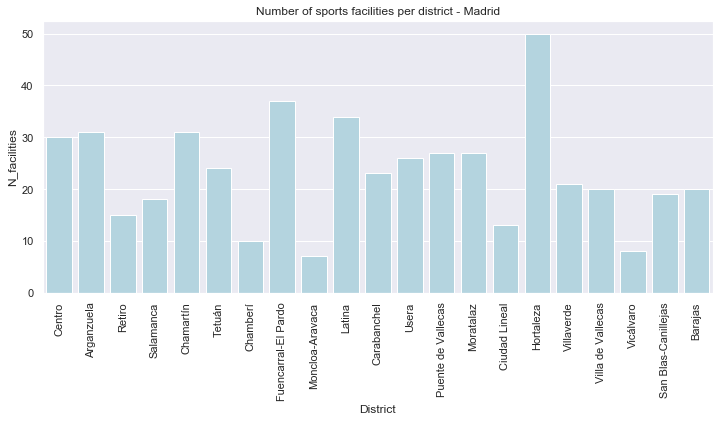

In [24]:
#Plot number of sports facilities per neighborhood for Madrid
ax = sns.barplot(x='District',y='N_facilities',data=madrid_districts, color='lightblue')
ax.set_title('Number of sports facilities per district - Madrid')
ax.set_xticklabels(labels=madrid_districts['District'],rotation=90);

In [25]:
# Prepare format for seaborn plots
sns.set()
sns.set(rc={'figure.figsize':(12,5)})

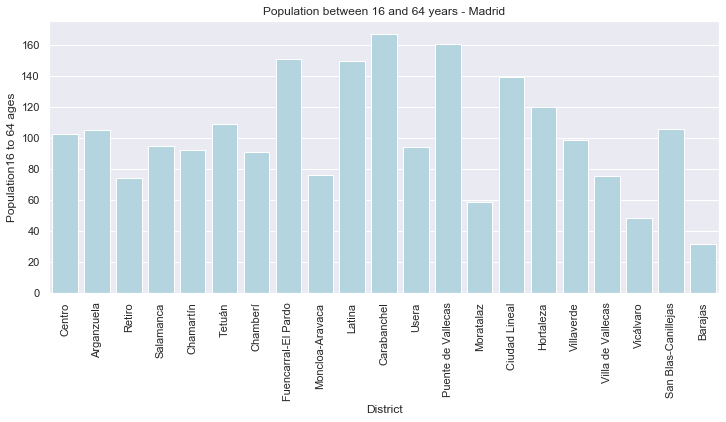

In [26]:
#Plot number of sports facilities per neighborhood for Madrid
ax = sns.barplot(x='District',y='Population16 to 64 ages',data=madrid_districts, color='lightblue')
ax.set_title('Population between 16 and 64 years - Madrid')
ax.set_xticklabels(labels=madrid_districts['District'],rotation=90);

### Explore Madrid venues using the Foursquare API

In [27]:
CLIENT_ID = 'S1UTEXJ40L40CPEOXV52UHYZKM2H4HOBBXVLGYXC4GG1JTNA' # your Foursquare ID
CLIENT_SECRET = 'RWGCJDKVW4JJR0505T5V0WKUDG3QIQJZQOZPPTSRDXTBURQ0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [29]:
madrid_venues = getNearbyVenues(names=madrid_districts['District'],
                                   latitudes=madrid_districts['Latitude'],
                                   longitudes=madrid_districts['Longitude']
                                  )

Centro
Arganzuela
Retiro
Salamanca
Chamartín
Tetuán
Chamberí
Fuencarral-El Pardo
Moncloa-Aravaca
Latina
Carabanchel
Usera
Puente de Vallecas
Moratalaz
Ciudad Lineal
Hortaleza
Villaverde
Villa de Vallecas
Vicálvaro
San Blas-Canillejas
Barajas


In [30]:
print('A total of {} venues were found in Madrid'.format(madrid_venues.shape[0]))
madrid_venues.head()

A total of 1813 venues were found in Madrid


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.418308,-3.70275,Puerta del Sol,40.417027,-3.703443,Plaza
1,Centro,40.418308,-3.70275,La Pulpería de Victoria,40.416506,-3.701709,Seafood Restaurant
2,Centro,40.418308,-3.70275,LUSH,40.419012,-3.704898,Cosmetics Shop
3,Centro,40.418308,-3.70275,Club del Gourmet Corte Ingles,40.417497,-3.704686,Gourmet Shop
4,Centro,40.418308,-3.70275,Rosi La Loca,40.415821,-3.702955,Tapas Restaurant


In [31]:
# Count the number of locations per Venue Category in Madrid
madrid_venues.groupby('Venue Category').count()['District'].sort_values(ascending=False).head()

Venue Category
Spanish Restaurant    164
Restaurant            101
Tapas Restaurant       69
Bar                    64
Hotel                  63
Name: District, dtype: int64

In [32]:
#Obtain the number of venues per district
venues = madrid_venues.groupby(['District'])['District'].count().to_frame()
#Fix title and remove multiindex
venues.rename(columns={'District':'N_venues'}, inplace=True)
venues.reset_index(inplace=True)
venues.head(3)

,District,N_venues
0,Arganzuela,100
1,Barajas,79
2,Carabanchel,100


In [33]:
# Prepare format for seaborn plots
sns.set()
sns.set(rc={'figure.figsize':(12,5)})

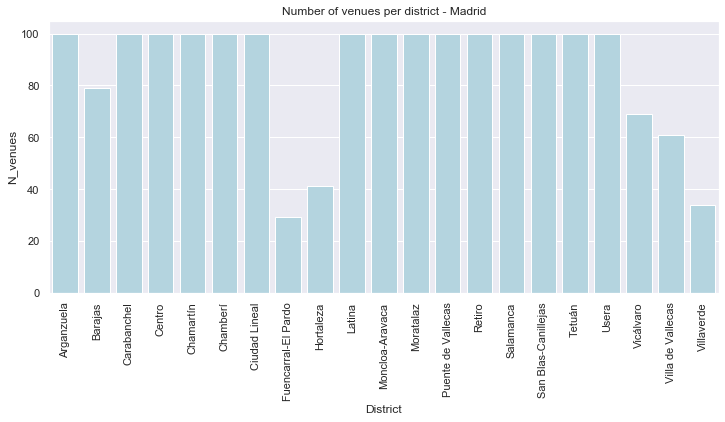

In [34]:
#Plot number of venues registered per neighborhood for Madrid
ax = sns.barplot(x='District',y='N_venues',data=venues, color='lightblue')
ax.set_title('Number of venues per district - Madrid')
ax.set_xticklabels(labels=venues['District'],rotation=90);

### Candidates districts: Ranking

Having explored the features of the 21 districts of the city of Madrid, a score will be given to each one in orden to establish a ranking and determinate the best 3 candidates.

The established criteria that will be used is given a score between 0 and 1 to each district. To generate these scores, a weight has been assigned to the different features studied.They are specified below:

    -Population between 16 and 64 years. Weight:25%
    
    -Number of sports facilities per district. Weight:50%
    
    -Number of venues per district. Weight:25%

The first step to create the ranking is forming resulting dataset and then normilize the three metrics.

In [35]:
#Crete the resulting dataset
madrid_districts=pd.merge(madrid_districts.sort_values('District',ascending=False), venues.sort_values('District',ascending=False),on='District')
madrid_districts.head()

,Number,District,Latitude,Longitude,Population16 to 64 ages,N_facilities,N_venues
0,17,Villaverde,40.349998,-3.70000,98.273,21,34
1,18,Villa de Vallecas,40.379600,-3.62135,75.338,20,61
2,19,Vicálvaro,40.404200,-3.60806,48.226,8,69
3,12,Usera,40.388660,-3.70035,93.873,26,100
4,6,Tetuán,40.459751,-3.69750,108.901,24,100


In [36]:
madrid_districts['Population_Normalized'] = madrid_districts['Population16 to 64 ages']/madrid_districts['Population16 to 64 ages'].max(axis=0)
madrid_districts['N_facilities_Normalized'] = madrid_districts['N_facilities']/madrid_districts['N_facilities'].max(axis=0)
madrid_districts['N_venues_Normalized'] = madrid_districts['N_venues']/madrid_districts['N_venues'].max(axis=0)
madrid_districts.head()

,Number,District,Latitude,Longitude,Population16 to 64 ages,N_facilities,N_venues,Population_Normalized,N_facilities_Normalized,N_venues_Normalized
0,17,Villaverde,40.349998,-3.70000,98.273,21,34,0.588510,0.42,0.34
1,18,Villa de Vallecas,40.379600,-3.62135,75.338,20,61,0.451164,0.40,0.61
2,19,Vicálvaro,40.404200,-3.60806,48.226,8,69,0.288803,0.16,0.69
3,12,Usera,40.388660,-3.70035,93.873,26,100,0.562161,0.52,1.00
4,6,Tetuán,40.459751,-3.69750,108.901,24,100,0.652156,0.48,1.00


In [37]:
madrid_districts['Score'] =0.25*madrid_districts['Population_Normalized']+0.25*madrid_districts['N_venues_Normalized']+0.5*madrid_districts['N_facilities_Normalized']
madrid_districts.head()

,Number,District,Latitude,Longitude,Population16 to 64 ages,N_facilities,N_venues,Population_Normalized,N_facilities_Normalized,N_venues_Normalized,Score
0,17,Villaverde,40.349998,-3.70000,98.273,21,34,0.588510,0.42,0.34,0.442128
1,18,Villa de Vallecas,40.379600,-3.62135,75.338,20,61,0.451164,0.40,0.61,0.465291
2,19,Vicálvaro,40.404200,-3.60806,48.226,8,69,0.288803,0.16,0.69,0.324701
3,12,Usera,40.388660,-3.70035,93.873,26,100,0.562161,0.52,1.00,0.650540
4,6,Tetuán,40.459751,-3.69750,108.901,24,100,0.652156,0.48,1.00,0.653039


### Results

In [38]:
madrid_districts=madrid_districts.sort_values('Score',ascending=False)
madrid_districts.reset_index(inplace=True, drop=True)
madrid_districts

,Number,District,Latitude,Longitude,Population16 to 64 ages,N_facilities,N_venues,Population_Normalized,N_facilities_Normalized,N_venues_Normalized,Score
0,10,Latina,40.388969,-3.745690,149.500,34,100,0.895285,0.68,1.00,0.813821
1,16,Hortaleza,40.474441,-3.641100,119.751,50,41,0.717132,1.00,0.41,0.781783
2,13,Puente de Vallecas,40.393540,-3.662000,160.115,27,100,0.958853,0.54,1.00,0.759713
3,11,Carabanchel,40.383669,-3.727989,166.986,23,100,1.000000,0.46,1.00,0.730000
4,2,Arganzuela,40.400021,-3.696180,104.784,31,100,0.627502,0.62,1.00,0.716875
5,1,Centro,40.418308,-3.702750,102.065,30,100,0.611219,0.60,1.00,0.702805
6,5,Chamartín,40.451000,-3.675000,91.757,31,100,0.549489,0.62,1.00,0.697372
7,8,Fuencarral-El Pardo,40.498402,-3.731400,150.648,37,29,0.902159,0.74,0.29,0.668040
8,6,Tetuán,40.459751,-3.697500,108.901,24,100,0.652156,0.48,1.00,0.653039
9,12,Usera,40.388660,-3.700350,93.873,26,100,0.562161,0.52,1.00,0.650540
